In [1]:
import pickle
from dataclasses import dataclass
import pandas as pd
import json
from typing import Optional
from drl_patches.sparse_autoencoders.get_vectorizer import load_tfidf_vectorizer
from drl_patches.sparse_autoencoders.getting_experiment_config import (
    load_training_indexes,
)
import torch
from drl_patches.logger import logger
from drl_patches.sparse_autoencoders.classical_data_mining import get_metrics
from drl_patches.sparse_autoencoders.utils import  set_seed
from drl_patches.sparse_autoencoders.vulnerability_detection_features import (
     get_vuln_safe_data
)
from drl_patches.sparse_autoencoders.getting_sorted_layer_features import (
    get_top_features,
    load_sorted_features,
)
from tqdm import trange
set_seed(42)
@dataclass
class Results:
    precision: float
    recall: float
    accuracy: float
    f1: float


@dataclass
class TransferabilityPerformance:
    on_defects: Optional[int] = None
    on_humaneval: Optional[int] = None
    on_gbug: Optional[int] = None

def calculate_f1_shift(
    results: Results,
    baseline_results: Results,
) -> dict:
    """
    Calculate the shift in perfoamcene in terms of F1 score % changed
    """
    f1_shift = (results.f1 - baseline_results.f1) / baseline_results.f1 * 100
    
    return f1_shift

# Save the results
def save_results(key, results, path="../artifacts/transferability_results.jsonl"):
    """
    Save the results to a jsonl file.
    """
    with open(path, "a") as f:
        f.write(json.dumps({key: results.__dict__}) + "\n")
    logger.info(f"Results saved to {path}")


2025-04-23 02:04:55 [info     ] Getting device.                device=cpu
2025-04-23 02:04:55 [info     ] Device                         device=cpu
2025-04-23 02:04:55 [info     ] Getting device.                device=cpu


In [2]:
@dataclass
class Dataset:
    dataset_path: str
    training_idx_path: str

GBUG_DATASET = Dataset(
    dataset_path="../artifacts/gbug-java.csv",
    training_idx_path="../artifacts/gbug-java_train_indexes.json",
)

DEFECT_DATASET = Dataset(
    dataset_path="../artifacts/defects4j.csv",
    training_idx_path="../artifacts/defects4j_train_indexes.json",
)

HUMAN_DATASET = Dataset(
    dataset_path="../artifacts/humaneval.csv",
    training_idx_path="../artifacts/humaneval_train_indexes.json",
)

In [ ]:

def get_testing_dataset(dataset: Dataset):
    """
    Get the testing dataset path and the training indexes path.
    """
    df = pd.read_csv(dataset.dataset_path)
    with open( dataset.training_idx_path, "r") as f:
        training_indices = json.load(f)
    train_df = df.loc[training_indices]
    test_df = df.drop(train_df.index)

    return train_df, test_df
def evaluate_clf(clf, test_df, top_k)-> Results:
    """
    Evaluate the model on the test dataset.
    """

    X_test = test_df[top_k]
    X_test = torch.tensor(X_test.values, dtype=torch.float32)

    y_test = test_df["vuln"]

    y_pred = clf.predict(X_test)
    tp = sum((y_pred == 1) & (y_test == 1))
    fp = sum((y_pred == 1) & (y_test == 0))
    tn = sum((y_pred == 0) & (y_test == 0))
    fn = sum((y_pred == 0) & (y_test == 1))


    # Calculate the accuracy
    accuracy = (tp + tn) / (tp + fp + fn + tn)
    # Calculate the precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    # Calculate the recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    # Calculate the F1 score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return Results(precision=precision, recall=recall, accuracy=accuracy, f1=f1)


In [96]:
@dataclass
class SAE_ACTIVATIONS:
    layer: int
    top_k: int
    original_dataset_path: str
    base_gbug_path: str = "../gpt2_gbug-java/"
    base_defects_path: str = "../gpt2_defects4j/"
    base_humaneval_path: str = "../gpt2_humaneval/"

    @property
    def gbug_feature_safe_path(self):
        return self.base_gbug_path + "layer" + str(self.layer) + "/feature_importance_safe.jsonl"
    
    @property
    def gbug_feature_vuln_path(self):
        return self.base_gbug_path + "layer" + str(self.layer) + "/feature_importance_vuln.jsonl"
    
    @property
    def defects_feature_safe_path(self):
        return self.base_defects_path + "layer" + str(self.layer) + "/feature_importance_safe.jsonl"
    
    @property
    def defects_feature_vuln_path(self):
        return self.base_defects_path + "layer" + str(self.layer) + "/feature_importance_vuln.jsonl"
    
    @property
    def humaneval_feature_safe_path(self):
        return self.base_humaneval_path + "layer" + str(self.layer) + "/feature_importance_safe.jsonl"
    
    @property
    def humaneval_feature_vuln_path(self):
        return self.base_humaneval_path + "layer" + str(self.layer) + "/feature_importance_vuln.jsonl"
    
    @property
    def model_path(self):
        return self.base_gbug_path + "layer" + str(self.layer) + "/random_forest_k_" + str(self.top_k) + ".pt"

    @property
    def most_important_features_path(self):
        return self.original_dataset_path + "layer" + str(self.layer) + "/most_important_features.json"
    
    @property
    def model_path(self):
        return self.original_dataset_path + "layer" + str(self.layer) + "/random_forest_k_" + str(self.top_k) + ".pt"
    
SAE_ACTIVATIONS_GBUG_GPT2 = SAE_ACTIVATIONS(
    layer=0,
    top_k=2000,
    original_dataset_path="../gpt2_gbug-java/",
)


SAE_ACTIVATIONS_DEFECTS4J = SAE_ACTIVATIONS(
    layer=0,
    top_k=2000,
    original_dataset_path="../gpt2_defects4j/",
)

SAE_ACTIVATIONS_HUMANEVL = SAE_ACTIVATIONS(
    layer=0,
    top_k=2000,
    original_dataset_path="../gpt2_humaneval/",
)




def load_sae_clf_settings(sae_activations: SAE_ACTIVATIONS):
    """
    Load the SAE classifier settings.
    """

    most_important_features = load_sorted_features(
        sae_activations.most_important_features_path
    )
    top_k = get_top_features(most_important_features, n=sae_activations.top_k)
    with open(sae_activations.model_path, "rb") as f:
        clf = pickle.load(f)

    return clf, top_k

def get_training_indexes(dataset: Dataset):
    with open(dataset.training_idx_path, "r") as f:
        training_indices = json.load(f)

    return training_indices

In [97]:
clf, top_k = load_sae_clf_settings(SAE_ACTIVATIONS_GBUG_GPT2)
# Original (GBUG)
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_GBUG_GPT2.gbug_feature_vuln_path,
    SAE_ACTIVATIONS_GBUG_GPT2.gbug_feature_safe_path,
    get_training_indexes(GBUG_DATASET),
)
sae_rf_gbug_gpt2 = evaluate_clf(clf, df_test, top_k)
print(sae_rf_gbug_gpt2)
# Defects4J
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_GBUG_GPT2.defects_feature_vuln_path,
    SAE_ACTIVATIONS_GBUG_GPT2.defects_feature_safe_path,
    get_training_indexes(DEFECT_DATASET),
)
sae_rf_gbug_gpt2_on_defects4j = evaluate_clf(clf, df_test, top_k)
print(sae_rf_gbug_gpt2_on_defects4j)
# Humaneval
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_GBUG_GPT2.humaneval_feature_vuln_path,
    SAE_ACTIVATIONS_GBUG_GPT2.humaneval_feature_safe_path,
    get_training_indexes(HUMAN_DATASET),
)

sae_rf_gbug_gpt2_on_humaneval = evaluate_clf(clf, df_test, top_k)
print(sae_rf_gbug_gpt2_on_humaneval)

transf_rf_gbug_gpt2_on_defects= calculate_f1_shift(
    sae_rf_gbug_gpt2_on_defects4j,
    sae_rf_gbug_gpt2,
)
transf_rf_gbug_gpt2_on_humaneval = calculate_f1_shift(
    sae_rf_gbug_gpt2_on_humaneval,
    sae_rf_gbug_gpt2,
)
transf_rf_gbug_gpt2 = TransferabilityPerformance(
    on_defects=transf_rf_gbug_gpt2_on_defects,
    on_humaneval=transf_rf_gbug_gpt2_on_humaneval,
)
save_results("sae_rf_gbug_gpt2", sae_rf_gbug_gpt2)
save_results("sae_rf_gbug_gpt2_on_defects4j", sae_rf_gbug_gpt2_on_defects4j)
save_results("sae_rf_gbug_gpt2_on_humaneval", sae_rf_gbug_gpt2_on_humaneval)
save_results("transf_rf_gbug_gpt2", transf_rf_gbug_gpt2)

100%|██████████| 24576/24576 [01:26<00:00, 285.53it/s]


Results(precision=0.6923076923076923, recall=0.6, accuracy=0.6666666666666666, f1=0.6428571428571429)


100%|██████████| 24576/24576 [01:32<00:00, 266.94it/s]


Results(precision=0.7407407407407407, recall=0.631578947368421, accuracy=0.7052631578947368, f1=0.6818181818181818)


100%|██████████| 24576/24576 [01:27<00:00, 279.91it/s]


Results(precision=0.75, recall=0.18181818181818182, accuracy=0.5606060606060606, f1=0.2926829268292683)
2025-04-23 23:49:20 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 23:49:20 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 23:49:20 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 23:49:20 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [106]:
print(transf_rf_gbug_gpt2)

TransferabilityPerformance(on_defects=6.060606060606045, on_humaneval=-54.47154471544716, on_gbug=None)


In [98]:
clf, top_k = load_sae_clf_settings( SAE_ACTIVATIONS_DEFECTS4J)
# Original (Defects4J)
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_DEFECTS4J.defects_feature_vuln_path,
    SAE_ACTIVATIONS_DEFECTS4J.defects_feature_safe_path,
    get_training_indexes(DEFECT_DATASET),
)
sae_rf_defects4j = evaluate_clf(clf, df_test, top_k)
print(sae_rf_defects4j)
# GBUG
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_DEFECTS4J.gbug_feature_vuln_path,
    SAE_ACTIVATIONS_DEFECTS4J.gbug_feature_safe_path,
    get_training_indexes(GBUG_DATASET),
)
sae_rf_defects4j_on_gbug = evaluate_clf(clf, df_test, top_k)
print(sae_rf_defects4j_on_gbug)
# Humaneval
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_DEFECTS4J.humaneval_feature_vuln_path,
    SAE_ACTIVATIONS_DEFECTS4J.humaneval_feature_safe_path,
    get_training_indexes(HUMAN_DATASET),
)
sae_rf_defects4j_on_humaneval = evaluate_clf(clf, df_test, top_k)
print(sae_rf_defects4j_on_humaneval)
transf_rf_defects4j_on_gbug = calculate_f1_shift(
    sae_rf_defects4j_on_gbug,
    sae_rf_defects4j,
)
transf_rf_defects4j_on_humaneval = calculate_f1_shift(
    sae_rf_defects4j_on_humaneval,
    sae_rf_defects4j,
)
transf_rf_defects4j_gpt2 = TransferabilityPerformance(
    on_gbug=transf_rf_defects4j_on_gbug,
    on_humaneval=transf_rf_defects4j_on_humaneval,
)
save_results("sae_rf_defects4j", sae_rf_defects4j)
save_results("sae_rf_defects4j_on_gbug", sae_rf_defects4j_on_gbug)
save_results("sae_rf_defects4j_on_humaneval", sae_rf_defects4j_on_humaneval)
save_results("transf_rf_defects4j_gpt2", transf_rf_defects4j_gpt2)

100%|██████████| 24576/24576 [01:31<00:00, 268.01it/s]


Results(precision=0.7333333333333333, recall=0.6947368421052632, accuracy=0.7210526315789474, f1=0.7135135135135134)


100%|██████████| 24576/24576 [01:36<00:00, 253.54it/s]


Results(precision=0.6129032258064516, recall=0.6333333333333333, accuracy=0.6166666666666667, f1=0.6229508196721313)


100%|██████████| 24576/24576 [01:27<00:00, 281.69it/s]


Results(precision=0.5, recall=0.09090909090909091, accuracy=0.5, f1=0.15384615384615385)
2025-04-23 23:54:12 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 23:54:12 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 23:54:12 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 23:54:12 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [99]:
clf, top_k = load_sae_clf_settings(SAE_ACTIVATIONS_HUMANEVL)
# Original (Humaneval)
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_HUMANEVL.humaneval_feature_vuln_path,
    SAE_ACTIVATIONS_HUMANEVL.humaneval_feature_safe_path,
    get_training_indexes(HUMAN_DATASET),
)
sae_rf_humaneval = evaluate_clf(clf, df_test, top_k)
print(sae_rf_humaneval)
# GBUG
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_HUMANEVL.gbug_feature_vuln_path,
    SAE_ACTIVATIONS_HUMANEVL.gbug_feature_safe_path,
    get_training_indexes(GBUG_DATASET),
)
sae_rf_humaneval_on_gbug = evaluate_clf(clf, df_test, top_k)
print(sae_rf_humaneval_on_gbug)
# Defects4J
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_HUMANEVL.defects_feature_vuln_path,
    SAE_ACTIVATIONS_HUMANEVL.defects_feature_safe_path,
    get_training_indexes(DEFECT_DATASET),
)
sae_rf_humaneval_on_defects4j = evaluate_clf(clf, df_test, top_k)
print(sae_rf_humaneval_on_defects4j)
transf_rf_humaneval_on_gbug = calculate_f1_shift(
    sae_rf_humaneval_on_gbug,
    sae_rf_humaneval,
)
transf_rf_humaneval_on_defects4j = calculate_f1_shift(
    sae_rf_humaneval_on_defects4j,
    sae_rf_humaneval,
)
transf_rf_humaneval_gpt2 = TransferabilityPerformance(
    on_defects=transf_rf_humaneval_on_defects4j,
    on_gbug=transf_rf_humaneval_on_gbug,
)
save_results("sae_rf_humaneval", sae_rf_humaneval)
save_results("sae_rf_humaneval_on_gbug", sae_rf_humaneval_on_gbug)
save_results("sae_rf_humaneval_on_defects4j", sae_rf_humaneval_on_defects4j)
save_results("transf_rf_humaneval_gpt2", transf_rf_humaneval_gpt2)



100%|██████████| 24576/24576 [01:30<00:00, 271.11it/s]


Results(precision=0.5897435897435898, recall=0.696969696969697, accuracy=0.6060606060606061, f1=0.638888888888889)


100%|██████████| 24576/24576 [01:31<00:00, 267.89it/s]


Results(precision=0.46511627906976744, recall=0.6666666666666666, accuracy=0.45, f1=0.547945205479452)


100%|██████████| 24576/24576 [01:34<00:00, 259.71it/s]


Results(precision=0.5161290322580645, recall=0.6736842105263158, accuracy=0.5210526315789473, f1=0.5844748858447488)
2025-04-23 23:59:06 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 23:59:06 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 23:59:06 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 23:59:06 [info     ] Results saved to ../artifacts/transferability_results.jsonl


## Gemma


In [ ]:
SAE_ACTIVATIONS_GBUG_GEMMA2 = SAE_ACTIVATIONS(
    layer=13,
    top_k=2,
    original_dataset_path="../gemma2_gbug-java/",
    base_gbug_path="../gemma2_gbug-java/",
    base_defects_path="../gemma2_defects4j/",
    base_humaneval_path="../gemma2_humaneval/"
)

SAE_ACTIVATIONS_DEFECTS4J_GEMMA2 = SAE_ACTIVATIONS(
    layer=7,
    top_k=1,
    original_dataset_path="../gemma2_defects4j/",
    base_gbug_path="../gemma2_gbug-java/",
    base_defects_path="../gemma2_defects4j/",
    base_humaneval_path="../gemma2_humaneval/"
)

SAE_ACTIVATIONS_HUMAN_GEMMA2 = SAE_ACTIVATIONS(
    layer=8,
    top_k=4,
    original_dataset_path="../gemma2_humaneval/",
    base_gbug_path="../gemma2_gbug-java/",
    base_defects_path="../gemma2_defects4j/",
    base_humaneval_path="../gemma2_humaneval/"
)





In [ ]:
clf, top_k = load_sae_clf_settings(SAE_ACTIVATIONS_GBUG_GEMMA2)
# Original (GBUG)
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_GBUG_GEMMA2.gbug_feature_vuln_path,
    SAE_ACTIVATIONS_GBUG_GEMMA2.gbug_feature_safe_path,
    get_training_indexes(GBUG_DATASET),
)
sae_rf_gbug_gemma2 = evaluate_clf(clf, df_test, top_k)
print(sae_rf_gbug_gemma2)
# Defects4J
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_GBUG_GEMMA2.defects_feature_vuln_path,
    SAE_ACTIVATIONS_GBUG_GEMMA2.defects_feature_safe_path,
    get_training_indexes(DEFECT_DATASET),
)
sae_rf_gbug_gemma2_on_defects4j = evaluate_clf(clf, df_test, top_k)
print(sae_rf_gbug_gemma2_on_defects4j)
# Humaneval
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_GBUG_GEMMA2.humaneval_feature_vuln_path,
    SAE_ACTIVATIONS_GBUG_GEMMA2.humaneval_feature_safe_path,
    get_training_indexes(HUMAN_DATASET),
)

sae_rf_gbug_gemma2_on_humaneval = evaluate_clf(clf, df_test, top_k)
print(sae_rf_gbug_gemma2_on_humaneval)

transf_rf_gbug_gemma2_on_defects= calculate_f1_shift(
    sae_rf_gbug_gemma2_on_defects4j,
    sae_rf_gbug_gemma2,
)
transf_rf_gbug_gemma2_on_humaneval = calculate_f1_shift(
    sae_rf_gbug_gemma2_on_humaneval,
    sae_rf_gbug_gemma2,
)
transf_rf_gbug_gemma2 = TransferabilityPerformance(
    on_defects=transf_rf_gbug_gemma2_on_defects,
    on_humaneval=transf_rf_gbug_gemma2_on_humaneval,
)
save_results("sae_rf_gbug_gemma2", sae_rf_gbug_gemma2)
save_results("sae_rf_gbug_gemma2_on_defects4j", sae_rf_gbug_gemma2_on_defects4j)
save_results("sae_rf_gbug_gemma2_on_humaneval", sae_rf_gbug_gemma2_on_humaneval)
save_results("transf_rf_gbug_gemma2", transf_rf_gbug_gemma2)

100%|██████████| 16384/16384 [00:34<00:00, 472.87it/s]


Results(precision=0.8846153846153846, recall=0.7666666666666667, accuracy=0.8333333333333334, f1=0.8214285714285715)


100%|██████████| 16384/16384 [00:39<00:00, 416.71it/s]


Results(precision=0.45348837209302323, recall=0.4105263157894737, accuracy=0.45789473684210524, f1=0.430939226519337)


100%|██████████| 16384/16384 [00:35<00:00, 457.61it/s]


Results(precision=0.5, recall=0.42424242424242425, accuracy=0.5, f1=0.4590163934426229)


In [ ]:
clf, top_k = load_sae_clf_settings(SAE_ACTIVATIONS_DEFECTS4J_GEMMA2)
# Original (GBUG)
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_DEFECTS4J_GEMMA2.defects_feature_vuln_path,
    SAE_ACTIVATIONS_DEFECTS4J_GEMMA2.defects_feature_safe_path,
    get_training_indexes(DEFECT_DATASET),
)
sae_rf_defects4j_gemma2 = evaluate_clf(clf, df_test, top_k)
print(sae_rf_defects4j_gemma2)
# GBUG
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_DEFECTS4J_GEMMA2.gbug_feature_vuln_path,
    SAE_ACTIVATIONS_DEFECTS4J_GEMMA2.gbug_feature_safe_path,
    get_training_indexes(GBUG_DATASET),
)
sae_rf_defects4j_gemma2_on_gbug = evaluate_clf(clf, df_test, top_k)
print(sae_rf_defects4j_gemma2_on_gbug)
# Humaneval
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_DEFECTS4J_GEMMA2.humaneval_feature_vuln_path,
    SAE_ACTIVATIONS_DEFECTS4J_GEMMA2.humaneval_feature_safe_path,
    get_training_indexes(HUMAN_DATASET),
)
sae_rf_defects4j_gemma2_on_humaneval = evaluate_clf(clf, df_test, top_k)
print(sae_rf_defects4j_gemma2_on_humaneval)
transf_rf_defects4j_gemma2_on_gbug = calculate_f1_shift(
    sae_rf_defects4j_gemma2_on_gbug,
    sae_rf_defects4j_gemma2,
)
transf_rf_defects4j_gemma2_on_humaneval = calculate_f1_shift(
    sae_rf_defects4j_gemma2_on_humaneval,
    sae_rf_defects4j_gemma2,
)
transf_rf_defects4j_gemma2 = TransferabilityPerformance(
    on_gbug=transf_rf_defects4j_gemma2_on_gbug,
    on_humaneval=transf_rf_defects4j_gemma2_on_humaneval,
)
save_results("sae_rf_defects4j_gemma2", sae_rf_defects4j_gemma2)
save_results("sae_rf_defects4j_gemma2_on_gbug", sae_rf_defects4j_gemma2_on_gbug)
save_results("sae_rf_defects4j_gemma2_on_humaneval", sae_rf_defects4j_gemma2_on_humaneval)
save_results("transf_rf_defects4j_gemma2", transf_rf_defects4j_gemma2)

100%|██████████| 16384/16384 [00:40<00:00, 400.83it/s]


Results(precision=0.5035460992907801, recall=0.7473684210526316, accuracy=0.5052631578947369, f1=0.6016949152542372)


100%|██████████| 16384/16384 [00:36<00:00, 451.72it/s]


Results(precision=0.4864864864864865, recall=0.6, accuracy=0.48333333333333334, f1=0.5373134328358209)


100%|██████████| 16384/16384 [00:36<00:00, 447.20it/s]


Results(precision=0.5, recall=1.0, accuracy=0.5, f1=0.6666666666666666)
2025-04-23 18:10:21 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 18:10:21 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 18:10:21 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 18:10:21 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [ ]:
clf, top_k = load_sae_clf_settings(SAE_ACTIVATIONS_HUMAN_GEMMA2)
# Original (Humaneval)
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_HUMAN_GEMMA2.humaneval_feature_vuln_path,
    SAE_ACTIVATIONS_HUMAN_GEMMA2.humaneval_feature_safe_path,
    get_training_indexes(HUMAN_DATASET),
)
sae_rf_humaneval_gemma2 = evaluate_clf(clf, df_test, top_k)
print(sae_rf_humaneval_gemma2)
# GBUG
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_HUMAN_GEMMA2.gbug_feature_vuln_path,
    SAE_ACTIVATIONS_HUMAN_GEMMA2.gbug_feature_safe_path,
    get_training_indexes(GBUG_DATASET),
)
sae_rf_humaneval_gemma2_on_gbug = evaluate_clf(clf, df_test, top_k)
print(sae_rf_humaneval_gemma2_on_gbug)
# Defects4J
_, df_test = get_vuln_safe_data(
    SAE_ACTIVATIONS_HUMAN_GEMMA2.defects_feature_vuln_path,
    SAE_ACTIVATIONS_HUMAN_GEMMA2.defects_feature_safe_path,
    get_training_indexes(DEFECT_DATASET),
)
sae_rf_humaneval_gemma2_on_defects4j = evaluate_clf(clf, df_test, top_k)
print(sae_rf_humaneval_gemma2_on_defects4j)
transf_rf_humaneval_gemma2_on_gbug = calculate_f1_shift(
    sae_rf_humaneval_gemma2_on_gbug,
    sae_rf_humaneval_gemma2,
)
transf_rf_humaneval_gemma2_on_defects4j = calculate_f1_shift(
    sae_rf_humaneval_gemma2_on_defects4j,
    sae_rf_humaneval_gemma2,
)
transf_rf_humaneval_gemma2 = TransferabilityPerformance(
    on_defects=transf_rf_humaneval_gemma2_on_defects4j,
    on_gbug=transf_rf_humaneval_gemma2_on_gbug,
)
save_results("sae_rf_humaneval_gemma2", sae_rf_humaneval_gemma2)
save_results("sae_rf_humaneval_gemma2_on_gbug", sae_rf_humaneval_gemma2_on_gbug)
save_results("sae_rf_humaneval_gemma2_on_defects4j", sae_rf_humaneval_gemma2_on_defects4j)
save_results("transf_rf_humaneval_gemma2", transf_rf_humaneval_gemma2)

100%|██████████| 16384/16384 [00:37<00:00, 431.79it/s]


Results(precision=0.5777777777777777, recall=0.7878787878787878, accuracy=0.6060606060606061, f1=0.6666666666666666)


100%|██████████| 16384/16384 [00:37<00:00, 431.23it/s]


Results(precision=0.5238095238095238, recall=0.36666666666666664, accuracy=0.5166666666666667, f1=0.4313725490196078)


100%|██████████| 16384/16384 [00:42<00:00, 386.62it/s]


Results(precision=0.5263157894736842, recall=0.42105263157894735, accuracy=0.5210526315789473, f1=0.4678362573099415)
2025-04-23 18:18:12 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 18:18:12 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 18:18:12 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 18:18:12 [info     ] Results saved to ../artifacts/transferability_results.jsonl


# Baselines Transferability

In [11]:
@dataclass
class BaselineClassifier:
    path: str
    tfidf_vectorizer_path: str
    base_dataset: Dataset
    input_size: int

DEFECTS4J_KNN_BASELINE = BaselineClassifier(
    path="../ole/defects4j_knn_k_5000.pt",
    tfidf_vectorizer_path = "../artifacts/vectorizer.pkl",
    base_dataset=DEFECT_DATASET,
    input_size=5000,
)
GBUG_KNN_BASELINE = BaselineClassifier(
    path="../ole/gbug_knn_k_5000.pt",
    tfidf_vectorizer_path = "../artifacts/vectorizer.pkl",
    base_dataset=GBUG_DATASET,
    input_size=5000,
)
HUMANEVAL_KNN_BASELINE = BaselineClassifier(
    path="../ole/human_knn_k_5000.pt",
    tfidf_vectorizer_path = "../artifacts/vectorizer.pkl",
    base_dataset=HUMAN_DATASET,
    input_size=5000,
)
DEFECTS4J_RF_BASELINE = BaselineClassifier(
    path="../ole/defects4j_random_forest_k_5000.pt",
    tfidf_vectorizer_path = "../artifacts/vectorizer.pkl",
    base_dataset=DEFECT_DATASET,
    input_size=5000,
)
GBUG_RF_BASELINE = BaselineClassifier(
    path="../ole/gbug_random_forest_k_5000.pt",
    tfidf_vectorizer_path = "../artifacts/vectorizer.pkl",
    base_dataset=GBUG_DATASET,
    input_size=5000,
)
HUMANEVAL_RF_BASELINE = BaselineClassifier(
    path="../ole/human_random_forest_k_5000.pt",
    tfidf_vectorizer_path = "../artifacts/vectorizer.pkl",
    base_dataset=HUMAN_DATASET,
    input_size=5000,
)

def load_baseline_classifier(classifier: BaselineClassifier):
    with open(classifier.path, "rb") as f:
        clf = pickle.load(f)
    return clf

def test_baseline_classifier(clf, 
                             vectorizer, 
                             df, 
                             train_indexes,
                             before_func_col="func_before", 
                             after_func_col="func_after") -> Results:
    """
    Test the baseline classifier on the test dataset.
    """

    df["tokenized_before"] = df[before_func_col].progress_apply(
        lambda x: vectorizer.transform([x]).toarray()[0]
    )
    df["tokenized_after"] = df[after_func_col].progress_apply(
        lambda x: vectorizer.transform([x]).toarray()[0]
    )
    # Pad to 5000 tokens
    df["tokenized_before"] = df["tokenized_before"].apply(
        lambda x: x[:5000] + [0] * (5000 - len(x)) if len(x) < 5000 else x[:5000]
    )
    df["tokenized_after"] = df["tokenized_after"].apply(
        lambda x: x[:5000] + [0] * (5000 - len(x)) if len(x) < 5000 else x[:5000]
    )

    df_test = df.drop(train_indexes)

    df_classical_test = pd.DataFrame()
    for row in df_test.iterrows():
        row = row[1]
        df_classical_test = pd.concat(
            [
                df_classical_test,
                pd.DataFrame(
                    {"tokens": [row["tokenized_before"].tolist()], "vuln": 1}, index=[0]
                ),
            ]
        )
        df_classical_test = pd.concat(
            [
                df_classical_test,
                pd.DataFrame(
                    {"tokens": [row["tokenized_after"].tolist()], "vuln": 0}, index=[0]
                ),
            ]
        )

    X_test = df_classical_test["tokens"].values.tolist()
    X_test = [torch.tensor(x) for x in X_test]
    y_test = df_classical_test["vuln"]

    # Get the prediction
    y_pred = clf.predict(X_test)
    precision, recall, accuracy, f1 = get_metrics(y_pred, y_test)
    logger.info(
        "Classification report:",
        precision=precision,
        recall=recall,
        accuracy=accuracy,
        f1=f1,
    )
    return Results(
        precision=precision,
        recall=recall,
        accuracy=accuracy,
        f1=f1,
    )
    



In [ ]:

results_gbug_knn = test_baseline_classifier(
    load_baseline_classifier(GBUG_KNN_BASELINE),
    load_tfidf_vectorizer(GBUG_KNN_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)

results_gbug_knn_defects = test_baseline_classifier(
    load_baseline_classifier(GBUG_KNN_BASELINE),
    load_tfidf_vectorizer(GBUG_KNN_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)

results_gbug_knn_human = test_baseline_classifier(
    load_baseline_classifier(GBUG_KNN_BASELINE),
    load_tfidf_vectorizer(GBUG_KNN_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)


transf_knn_gbug_on_defects= calculate_f1_shift(
    results_gbug_knn_defects,
    results_gbug_knn,
)
transf_knn_gbug_on_human= calculate_f1_shift(
    results_gbug_knn_human,
    results_gbug_knn,
)

transf_knn_gbug = TransferabilityPerformance(
    on_defects=transf_knn_gbug_on_defects,
    on_humaneval=transf_knn_gbug_on_human,
)

save_results("results_gbug_knn", results_gbug_knn)
save_results("results_gbug_knn_defects", results_gbug_knn_defects)
save_results("results_gbug_knn_human", results_gbug_knn_human)
save_results("transf_knn_gbug", transf_knn_gbug)


100%|██████████| 148/148 [00:00<00:00, 1969.76it/s]


2025-04-23 02:19:31 [info     ] Classification report:         accuracy=0.6666666666666666 f1=0.6774193548387096 precision=0.65625 recall=0.7


100%|██████████| 465/465 [00:00<00:00, 4472.65it/s]


2025-04-23 02:19:31 [info     ] Classification report:         accuracy=0.5 f1=0.4431137724550898 precision=0.5 recall=0.3978494623655914


100%|██████████| 162/162 [00:00<00:00, 7747.57it/s]


2025-04-23 02:19:31 [info     ] Classification report:         accuracy=0.48484848484848486 f1=0.43333333333333324 precision=0.48148148148148145 recall=0.3939393939393939
2025-04-23 02:19:31 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:19:31 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:19:31 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [ ]:
### Random Forest from Gbug
results_gbug_rf = test_baseline_classifier(
    load_baseline_classifier(GBUG_RF_BASELINE),
    load_tfidf_vectorizer(GBUG_RF_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)

results_gbug_rf_defects = test_baseline_classifier(
    load_baseline_classifier(GBUG_RF_BASELINE),
    load_tfidf_vectorizer(GBUG_RF_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)

results_gbug_rf_human = test_baseline_classifier(
    load_baseline_classifier(GBUG_KNN_BASELINE),
    load_tfidf_vectorizer(GBUG_KNN_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)

transf_rf_gbug_on_defects= calculate_f1_shift(
    results_gbug_rf_defects,
    results_gbug_rf,
)
transf_rf_gbug_on_human= calculate_f1_shift(
    results_gbug_rf_human,
    results_gbug_rf,
)

transf_rf_gbug = TransferabilityPerformance(
    on_defects=transf_rf_gbug_on_defects,
    on_humaneval=transf_rf_gbug_on_human,
)

save_results("results_gbug_rf", results_gbug_rf)
save_results("results_gbug_rf_defects", results_gbug_rf_defects)
save_results("results_gbug_rf_human", results_gbug_rf_human)
save_results("transf_knn_gbug", transf_knn_gbug)

100%|██████████| 148/148 [00:00<00:00, 4707.23it/s]


2025-04-23 02:19:31 [info     ] Classification report:         accuracy=0.75 f1=0.7058823529411764 precision=0.8571428571428571 recall=0.6


100%|██████████| 465/465 [00:00<00:00, 6968.28it/s]


2025-04-23 02:19:31 [info     ] Classification report:         accuracy=0.5161290322580645 f1=0.1176470588235294 precision=0.6666666666666666 recall=0.06451612903225806


100%|██████████| 162/162 [00:00<00:00, 3073.25it/s]


2025-04-23 02:19:32 [info     ] Classification report:         accuracy=0.48484848484848486 f1=0.43333333333333324 precision=0.48148148148148145 recall=0.3939393939393939
2025-04-23 02:19:32 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:19:32 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:19:32 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [ ]:
results_defects_knn = test_baseline_classifier(
    load_baseline_classifier(DEFECTS4J_KNN_BASELINE),
    load_tfidf_vectorizer(DEFECTS4J_KNN_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
results_defects_knn_gbug = test_baseline_classifier(
    load_baseline_classifier(DEFECTS4J_KNN_BASELINE),
    load_tfidf_vectorizer(DEFECTS4J_KNN_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_defects_knn_human = test_baseline_classifier(
    load_baseline_classifier(DEFECTS4J_KNN_BASELINE),
    load_tfidf_vectorizer(DEFECTS4J_KNN_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
transf_knn_defects_on_gbug= calculate_f1_shift(
    results_defects_knn_gbug,
    results_defects_knn,
)
transf_knn_defects_on_human= calculate_f1_shift(
    results_defects_knn_human,
    results_defects_knn,
)

transf_knn_defects = TransferabilityPerformance(
    on_gbug=transf_knn_defects_on_gbug,
    on_humaneval=transf_knn_defects_on_human,
)
save_results("results_defects_knn", results_defects_knn)
save_results("results_defects_knn_gbug", results_defects_knn_gbug)
save_results("results_defects_knn_human", results_defects_knn_human)
save_results("transf_knn_defects", transf_knn_defects)

100%|██████████| 465/465 [00:00<00:00, 4252.21it/s]


2025-04-23 18:23:34 [info     ] Classification report:         accuracy=0.5376344086021505 f1=0.35820895522388063 precision=0.5853658536585366 recall=0.25806451612903225


100%|██████████| 148/148 [00:00<00:00, 5272.36it/s]

2025-04-23 18:23:34 [info     ] Classification report:         accuracy=0.5333333333333333 f1=0.43999999999999995 precision=0.55 recall=0.36666666666666664



100%|██████████| 162/162 [00:00<00:00, 8233.39it/s]


2025-04-23 18:23:34 [info     ] Classification report:         accuracy=0.5454545454545454 f1=0.4642857142857143 precision=0.5652173913043478 recall=0.3939393939393939
2025-04-23 18:23:34 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 18:23:34 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 18:23:34 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [ ]:
results_defects_rf = test_baseline_classifier(
    load_baseline_classifier(DEFECTS4J_RF_BASELINE),
    load_tfidf_vectorizer(DEFECTS4J_RF_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
results_defects_rf_gbug = test_baseline_classifier(
    load_baseline_classifier(DEFECTS4J_RF_BASELINE),
    load_tfidf_vectorizer(DEFECTS4J_RF_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_defects_rf_human = test_baseline_classifier(
    load_baseline_classifier(DEFECTS4J_RF_BASELINE),
    load_tfidf_vectorizer(DEFECTS4J_RF_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
transf_rf_defects_on_gbug= calculate_f1_shift(
    results_defects_rf_gbug,
    results_defects_rf,
)
transf_rf_defects_on_human= calculate_f1_shift(
    results_defects_rf_human,
    results_defects_rf,
)

transf_rf_defects = TransferabilityPerformance(
    on_gbug=transf_rf_defects_on_gbug,
    on_humaneval=transf_rf_defects_on_human,
)
save_results("results_defects_rf", results_defects_rf)
save_results("results_defects_rf_gbug", results_defects_rf_gbug)
save_results("results_defects_rf_human", results_defects_rf_human)
save_results("transf_rf_defects", transf_knn_defects)

100%|██████████| 465/465 [00:00<00:00, 7014.32it/s]


2025-04-23 02:19:33 [info     ] Classification report:         accuracy=0.521505376344086 f1=0.41830065359477125 precision=0.5333333333333333 recall=0.34408602150537637


100%|██████████| 148/148 [00:00<00:00, 5194.45it/s]


2025-04-23 02:19:33 [info     ] Classification report:         accuracy=0.5333333333333333 f1=0.36363636363636365 precision=0.5714285714285714 recall=0.26666666666666666


100%|██████████| 162/162 [00:00<00:00, 5784.85it/s]


2025-04-23 02:19:33 [info     ] Classification report:         accuracy=0.5 f1=0.6117647058823529 precision=0.5 recall=0.7878787878787878
2025-04-23 02:19:33 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:19:33 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:19:33 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [ ]:
results_humaneval_knn = test_baseline_classifier(
    load_baseline_classifier(HUMANEVAL_KNN_BASELINE),
    load_tfidf_vectorizer(HUMANEVAL_KNN_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
results_humaneval_knn_gbug = test_baseline_classifier(
    load_baseline_classifier(HUMANEVAL_KNN_BASELINE),
    load_tfidf_vectorizer(HUMANEVAL_KNN_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_humaneval_knn_defects = test_baseline_classifier(
    load_baseline_classifier(HUMANEVAL_KNN_BASELINE),
    load_tfidf_vectorizer(HUMANEVAL_KNN_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
transf_knn_humaneval_on_gbug= calculate_f1_shift(
    results_humaneval_knn_gbug,
    results_humaneval_knn,
)
transf_knn_humaneval_on_defects= calculate_f1_shift(
    results_humaneval_knn_defects,
    results_humaneval_knn,
)

save_results("results_humaneval_knn", results_humaneval_knn)
save_results("results_humaneval_knn_gbug", results_humaneval_knn_gbug)
save_results("results_humaneval_knn_defects", results_humaneval_knn_defects)

transf_knn_humaneval = TransferabilityPerformance(
    on_gbug=transf_knn_humaneval_on_gbug,
    on_defects=transf_knn_humaneval_on_defects,
    on_humaneval=None,
)
print(transf_knn_humaneval)
save_results("transf_knn_humaneval", transf_knn_humaneval)

100%|██████████| 162/162 [00:00<00:00, 3960.40it/s]


2025-04-23 02:19:33 [info     ] Classification report:         accuracy=0.5757575757575758 f1=0.5625 precision=0.5806451612903226 recall=0.5454545454545454


100%|██████████| 148/148 [00:00<00:00, 5162.74it/s]


2025-04-23 02:19:33 [info     ] Classification report:         accuracy=0.48333333333333334 f1=0.5373134328358209 precision=0.4864864864864865 recall=0.6


100%|██████████| 465/465 [00:00<00:00, 6590.29it/s]


2025-04-23 02:19:33 [info     ] Classification report:         accuracy=0.5053763440860215 f1=0.5 precision=0.5054945054945055 recall=0.4946236559139785
2025-04-23 02:19:33 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:19:33 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:19:33 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [ ]:
results_humaneval_rf = test_baseline_classifier(
    load_baseline_classifier(HUMANEVAL_RF_BASELINE),
    load_tfidf_vectorizer(HUMANEVAL_RF_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
results_humaneval_rf_gbug = test_baseline_classifier(
    load_baseline_classifier(HUMANEVAL_RF_BASELINE),
    load_tfidf_vectorizer(HUMANEVAL_RF_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_humaneval_rf_defects = test_baseline_classifier(
    load_baseline_classifier(HUMANEVAL_RF_BASELINE),
    load_tfidf_vectorizer(HUMANEVAL_RF_BASELINE.tfidf_vectorizer_path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
transf_rf_humaneval_on_gbug= calculate_f1_shift(
    results_humaneval_rf_gbug,
    results_humaneval_rf,
)
transf_rf_humaneval_on_defects= calculate_f1_shift(
    results_humaneval_rf_defects,
    results_humaneval_rf,
)
transf_rf_humaneval = TransferabilityPerformance(
    on_defects=transf_rf_humaneval_on_defects,
    on_gbug=transf_rf_humaneval_on_gbug,
)
save_results("results_humaneval_rf", results_humaneval_rf)
save_results("results_humaneval_rf_gbug", results_humaneval_rf_gbug)
save_results("results_humaneval_rf_defects", results_humaneval_rf_defects)
save_results("transf_rf_humaneval", transf_rf_humaneval)

100%|██████████| 162/162 [00:00<00:00, 7290.68it/s]


2025-04-23 02:19:34 [info     ] Classification report:         accuracy=0.5606060606060606 f1=0.4912280701754386 precision=0.5833333333333334 recall=0.42424242424242425


100%|██████████| 148/148 [00:00<00:00, 5132.47it/s]

2025-04-23 02:19:34 [info     ] Classification report:         accuracy=0.5 f1=0.16666666666666669 precision=0.5 recall=0.1



100%|██████████| 465/465 [00:00<00:00, 4473.26it/s]


2025-04-23 02:19:34 [info     ] Classification report:         accuracy=0.4946236559139785 f1=0.11320754716981131 precision=0.46153846153846156 recall=0.06451612903225806
2025-04-23 02:19:34 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:19:34 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:19:34 [info     ] Results saved to ../artifacts/transferability_results.jsonl


# Baselines with BERT-based model

In [24]:
@dataclass
class BERT_CLASSIFIER:
    path: str
    
MODERN_BERT_BASE_GBUG = BERT_CLASSIFIER(
    path="../answerdotai_ModernBERT-base_artifacts_gbug-java.csv_best_model",
)

MODERN_BERT_BASE_DEFECTS = BERT_CLASSIFIER(
    path="../answerdotai_ModernBERT-base_artifacts_defects4j.csv_best_model",
)
MODERN_BERT_BASE_HUMAN = BERT_CLASSIFIER(
    path="../answerdotai_ModernBERT-base_artifacts_humaneval.csv_best_model",
)
MODERN_BERT_LARGE_GBUG = BERT_CLASSIFIER(
    path="../answerdotai_ModernBERT-large_artifacts_gbug-java.csv_best_model",
)
MODERN_BERT_LARGE_DEFECTS = BERT_CLASSIFIER(
    path="../answerdotai_ModernBERT-large_artifacts_defects4j.csv_best_model",
)
MODERN_BERT_LARGE_HUMAN = BERT_CLASSIFIER(
    path="../answerdotai_ModernBERT-large_artifacts_humaneval.csv_best_model",
)
GRAPH_CODE_BERT_GBUG = BERT_CLASSIFIER(
    path="../microsoft_graphcodebert-base_artifacts_gbug-java.csv_best_model",
)
GRAPH_CODE_BERT_DEFECTS = BERT_CLASSIFIER(
    path="../microsoft_graphcodebert-base_artifacts_defects4j.csv_best_model",
)
GRAPH_CODE_BERT_HUMAN = BERT_CLASSIFIER(
    path="../microsoft_graphcodebert-base_artifacts_humaneval.csv_best_model",
)


In [25]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
def load_bert_model(model_path: str):
    """
    Load the BERT model from the given path.
    """
    model = AutoModelForSequenceClassification.from_pretrained(model_path,  trust_remote_code=True)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    return model, tokenizer

def test_bert_model(model, tokenizer, df, train_indexes):
    """
    Test the BERT model on the test dataset.
    """
    df_test = df.drop(train_indexes)

    X_test = df_test["func_before"].tolist() + df_test["func_after"].tolist()
    y_test = [1] * len(df_test) + [0] * len(df_test)

    y_pred_all = []

    for i in trange(len(X_test)):
        inputs = tokenizer(
            X_test[i],
            padding=True,
            truncation=True,
            return_tensors="pt",
        )

        outputs = model(**inputs)
        logits = outputs.logits
        y_pred = torch.argmax(logits, dim=1)
        y_pred_all.append(y_pred.item())
        
    
    precision, recall, accuracy, f1 = get_metrics(y_pred_all, y_test)
    logger.info(
        "Classification report:",
        precision=precision,
        recall=recall,
        accuracy=accuracy,
        f1=f1,
    )
    return Results(
        precision=precision,
        recall=recall,
        accuracy=accuracy,
        f1=f1,
    )


In [26]:
results_modern_bert_large_gbug = test_bert_model(
    *load_bert_model(MODERN_BERT_LARGE_GBUG.path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_modern_bert_large_gbug_on_defects = test_bert_model(
    *load_bert_model(MODERN_BERT_LARGE_GBUG.path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)

results_modern_bert_large_gbug_on_human = test_bert_model(
    *load_bert_model(MODERN_BERT_LARGE_GBUG.path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
transf_modern_bert_large_gbug_on_defects= calculate_f1_shift(
    results_modern_bert_large_gbug_on_defects,
    results_modern_bert_large_gbug,
)
transf_modern_bert_large_gbug_on_human= calculate_f1_shift(
    results_modern_bert_large_gbug_on_human,
    results_modern_bert_large_gbug,
)

# Save the results
save_results(
    "results_modern_bert_large_gbug",
    results_modern_bert_large_gbug,
)
save_results(
    "results_modern_bert_large_gbug_on_defects",
    results_modern_bert_large_gbug_on_defects,
)
save_results(
    "results_modern_bert_large_gbug_on_human",
    results_modern_bert_large_gbug_on_human,
)

100%|██████████| 60/60 [00:50<00:00,  1.18it/s]

2025-04-23 02:20:26 [info     ] Classification report:         accuracy=0.7 f1=0.71875 precision=0.6764705882352942 recall=0.7666666666666667



100%|██████████| 186/186 [02:05<00:00,  1.49it/s]

2025-04-23 02:22:31 [info     ] Classification report:         accuracy=0.553763440860215 f1=0.5464480874316939 precision=0.5555555555555556 recall=0.5376344086021505



100%|██████████| 66/66 [00:14<00:00,  4.47it/s]

2025-04-23 02:22:46 [info     ] Classification report:         accuracy=0.5151515151515151 f1=0.5999999999999999 precision=0.5106382978723404 recall=0.7272727272727273
2025-04-23 02:22:46 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:22:46 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:22:46 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [27]:
transf_modern_bert_large_gbug = TransferabilityPerformance(
    on_defects=transf_modern_bert_large_gbug_on_defects,
    on_humaneval=transf_modern_bert_large_gbug_on_human,
)
save_results("transf_modern_bert_large_gbug", transf_modern_bert_large_gbug)

2025-04-23 02:22:46 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [28]:
results_modern_bert_large_defects = test_bert_model(
    *load_bert_model(MODERN_BERT_LARGE_DEFECTS.path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
results_modern_bert_large_defects_on_gbug = test_bert_model(
    *load_bert_model(MODERN_BERT_LARGE_DEFECTS.path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_modern_bert_large_defects_on_human = test_bert_model(
    *load_bert_model(MODERN_BERT_LARGE_DEFECTS.path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
transf_modern_bert_large_defects_on_gbug= calculate_f1_shift(
    results_modern_bert_large_defects_on_gbug,
    results_modern_bert_large_defects,
)
transf_modern_bert_large_defects_on_human= calculate_f1_shift(
    results_modern_bert_large_defects_on_human,
    results_modern_bert_large_defects,
)
# Save the results
save_results(
    "results_modern_bert_large_defects",
    results_modern_bert_large_defects,
)
save_results(
    "results_modern_bert_large_defects_on_gbug",
    results_modern_bert_large_defects_on_gbug,
)
save_results(
    "results_modern_bert_large_defects_on_human",
    results_modern_bert_large_defects_on_human,
)

100%|██████████| 186/186 [02:11<00:00,  1.42it/s]

2025-04-23 02:24:57 [info     ] Classification report:         accuracy=0.5268817204301075 f1=0.5510204081632653 precision=0.5242718446601942 recall=0.5806451612903226



100%|██████████| 60/60 [00:49<00:00,  1.21it/s]

2025-04-23 02:25:47 [info     ] Classification report:         accuracy=0.5166666666666667 f1=0.5671641791044775 precision=0.5135135135135135 recall=0.6333333333333333



100%|██████████| 66/66 [00:15<00:00,  4.36it/s]

2025-04-23 02:26:03 [info     ] Classification report:         accuracy=0.5303030303030303 f1=0.5753424657534246 precision=0.525 recall=0.6363636363636364
2025-04-23 02:26:03 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:26:03 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:26:03 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [29]:
transf_modern_bert_large_defects = TransferabilityPerformance(
    on_defects=transf_modern_bert_large_defects_on_gbug,
    on_humaneval=transf_modern_bert_large_defects_on_human,
)
save_results("transf_modern_bert_large_defects", transf_modern_bert_large_defects)

2025-04-23 02:26:03 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [30]:
results_modern_bert_large_humaneval = test_bert_model(
    *load_bert_model(MODERN_BERT_LARGE_HUMAN.path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
results_modern_bert_large_humaneval_on_gbug = test_bert_model(
    *load_bert_model(MODERN_BERT_LARGE_HUMAN.path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_modern_bert_large_humaneval_on_defects = test_bert_model(
    *load_bert_model(MODERN_BERT_LARGE_HUMAN.path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
transf_modern_bert_large_humaneval_on_gbug= calculate_f1_shift(
    results_modern_bert_large_humaneval_on_gbug,
    results_modern_bert_large_humaneval,
)
transf_modern_bert_large_humaneval_on_defects= calculate_f1_shift(
    results_modern_bert_large_humaneval_on_defects,
    results_modern_bert_large_humaneval,
)
# Save the results
save_results(
    "results_modern_bert_large_humaneval",
    results_modern_bert_large_humaneval,
)
save_results(
    "results_modern_bert_large_humaneval_on_gbug",
    results_modern_bert_large_humaneval_on_gbug,
)

100%|██████████| 66/66 [00:15<00:00,  4.14it/s]

2025-04-23 02:26:19 [info     ] Classification report:         accuracy=0.5606060606060606 f1=0.5797101449275361 precision=0.5555555555555556 recall=0.6060606060606061



100%|██████████| 60/60 [00:48<00:00,  1.23it/s]

2025-04-23 02:27:08 [info     ] Classification report:         accuracy=0.5 f1=0.37499999999999994 precision=0.5 recall=0.3



100%|██████████| 186/186 [02:06<00:00,  1.47it/s]

2025-04-23 02:29:14 [info     ] Classification report:         accuracy=0.553763440860215 f1=0.4429530201342282 precision=0.5892857142857143 recall=0.3548387096774194
2025-04-23 02:29:14 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:29:14 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [31]:
transf_modern_bert_large_humaneval = TransferabilityPerformance(
    on_defects=transf_modern_bert_large_humaneval_on_defects,
    on_gbug=transf_modern_bert_large_humaneval_on_gbug,
)
save_results(
    "transf_modern_bert_large_humaneval",
    transf_modern_bert_large_humaneval,
)

2025-04-23 02:29:14 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [32]:
results_modern_bert_base_gbug = test_bert_model(
    *load_bert_model(MODERN_BERT_BASE_GBUG.path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)

results_modern_bert_base_gbug_on_defects = test_bert_model(
    *load_bert_model(MODERN_BERT_BASE_GBUG.path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
results_modern_bert_base_gbug_on_human = test_bert_model(
    *load_bert_model(MODERN_BERT_BASE_GBUG.path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
transf_modern_bert_base_gbug_on_defects= calculate_f1_shift(
    results_modern_bert_base_gbug_on_defects,
    results_modern_bert_base_gbug,
)
transf_modern_bert_base_gbug_on_human= calculate_f1_shift(
    results_modern_bert_base_gbug_on_human,
    results_modern_bert_base_gbug,
)
# Save the results
save_results(
    "results_modern_bert_base_gbug",
    results_modern_bert_base_gbug,
)
save_results(
    "results_modern_bert_base_gbug_on_defects",
    results_modern_bert_base_gbug_on_defects,
)
save_results(
    "results_modern_bert_base_gbug_on_human",
    results_modern_bert_base_gbug_on_human,
)
transf_modern_bert_base_gbug = TransferabilityPerformance(
    on_defects=transf_modern_bert_base_gbug_on_defects,
    on_humaneval=transf_modern_bert_base_gbug_on_human,
)
save_results("transf_modern_bert_base_gbug", transf_modern_bert_base_gbug)

100%|██████████| 60/60 [00:25<00:00,  2.35it/s]

2025-04-23 02:29:40 [info     ] Classification report:         accuracy=0.6666666666666666 f1=0.7142857142857143 precision=0.625 recall=0.8333333333333334



100%|██████████| 186/186 [01:05<00:00,  2.86it/s]

2025-04-23 02:30:45 [info     ] Classification report:         accuracy=0.532258064516129 f1=0.42384105960264906 precision=0.5517241379310345 recall=0.34408602150537637



100%|██████████| 66/66 [00:06<00:00, 10.83it/s]

2025-04-23 02:30:51 [info     ] Classification report:         accuracy=0.5757575757575758 f1=0.5172413793103449 precision=0.6 recall=0.45454545454545453
2025-04-23 02:30:51 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:30:51 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:30:51 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:30:51 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [33]:
results_modern_bert_base_defects = test_bert_model(
    *load_bert_model(MODERN_BERT_BASE_DEFECTS.path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
results_modern_bert_base_defects_on_gbug = test_bert_model(
    *load_bert_model(MODERN_BERT_BASE_DEFECTS.path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_modern_bert_base_defects_on_human = test_bert_model(
    *load_bert_model(MODERN_BERT_BASE_DEFECTS.path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
transf_modern_bert_base_defects_on_gbug= calculate_f1_shift(
    results_modern_bert_base_defects_on_gbug,
    results_modern_bert_base_defects,
)
transf_modern_bert_base_defects_on_human= calculate_f1_shift(
    results_modern_bert_base_defects_on_human,
    results_modern_bert_base_defects,
)
# Save the results
save_results(
    "results_modern_bert_base_defects",
    results_modern_bert_base_defects,
)
save_results(
    "results_modern_bert_base_defects_on_gbug",
    results_modern_bert_base_defects_on_gbug,
)
save_results(
    "results_modern_bert_base_defects_on_human",
    results_modern_bert_base_defects_on_human,
)

100%|██████████| 186/186 [01:03<00:00,  2.91it/s]

2025-04-23 02:31:56 [info     ] Classification report:         accuracy=0.553763440860215 f1=0.48447204968944096 precision=0.5735294117647058 recall=0.41935483870967744



100%|██████████| 60/60 [00:24<00:00,  2.49it/s]

2025-04-23 02:32:20 [info     ] Classification report:         accuracy=0.5333333333333333 f1=0.5172413793103449 precision=0.5357142857142857 recall=0.5



100%|██████████| 66/66 [00:06<00:00, 10.09it/s]

2025-04-23 02:32:26 [info     ] Classification report:         accuracy=0.5 f1=0.5714285714285715 precision=0.5 recall=0.6666666666666666
2025-04-23 02:32:26 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:32:26 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:32:26 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [34]:

transf_modern_bert_base_defects = TransferabilityPerformance(
    on_gbug=transf_modern_bert_base_defects_on_gbug,
    on_humaneval=transf_modern_bert_base_defects_on_human,
)
save_results("transf_modern_bert_base_defects", transf_modern_bert_base_defects)

2025-04-23 02:32:26 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [35]:
results_modern_bert_base_humaneval = test_bert_model(
    *load_bert_model(MODERN_BERT_BASE_HUMAN.path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
results_modern_bert_base_humaneval_on_gbug = test_bert_model(
    *load_bert_model(MODERN_BERT_BASE_HUMAN.path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_modern_bert_base_humaneval_on_defects = test_bert_model(
    *load_bert_model(MODERN_BERT_BASE_HUMAN.path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
transf_modern_bert_base_humaneval_on_gbug= calculate_f1_shift(
    results_modern_bert_base_humaneval_on_gbug,
    results_modern_bert_base_humaneval,
)
transf_modern_bert_base_humaneval_on_defects= calculate_f1_shift(
    results_modern_bert_base_humaneval_on_defects,
    results_modern_bert_base_humaneval,
)

# Save the results
save_results(
    "results_modern_bert_base_humaneval",
    results_modern_bert_base_humaneval,
)
save_results(
    "results_modern_bert_base_humaneval_on_gbug",
    results_modern_bert_base_humaneval_on_gbug,
)
save_results(
    "results_modern_bert_base_humaneval_on_defects",
    results_modern_bert_base_humaneval_on_defects,
)
transf_modern_bert_base_humaneval = TransferabilityPerformance(
    on_defects=transf_modern_bert_base_humaneval_on_defects,
    on_gbug=transf_modern_bert_base_humaneval_on_gbug,
)
save_results(
    "transf_modern_bert_base_humaneval",
    transf_modern_bert_base_humaneval,
)

100%|██████████| 66/66 [00:07<00:00,  8.84it/s]

2025-04-23 02:32:34 [info     ] Classification report:         accuracy=0.6060606060606061 f1=0.6285714285714286 precision=0.5945945945945946 recall=0.6666666666666666



100%|██████████| 60/60 [00:24<00:00,  2.45it/s]

2025-04-23 02:32:59 [info     ] Classification report:         accuracy=0.5166666666666667 f1=0.4081632653061224 precision=0.5263157894736842 recall=0.3333333333333333



100%|██████████| 186/186 [01:02<00:00,  2.97it/s]

2025-04-23 02:34:01 [info     ] Classification report:         accuracy=0.5698924731182796 f1=0.47368421052631576 precision=0.6101694915254238 recall=0.3870967741935484
2025-04-23 02:34:01 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:34:01 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:34:01 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:34:01 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [36]:
results_graph_code_bert_gbug = test_bert_model(
    *load_bert_model(GRAPH_CODE_BERT_GBUG.path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_graph_code_bert_gbug_on_defects = test_bert_model(
    *load_bert_model(GRAPH_CODE_BERT_GBUG.path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
results_graph_code_bert_gbug_on_human = test_bert_model(
    *load_bert_model(GRAPH_CODE_BERT_GBUG.path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
transf_graph_code_bert_gbug_on_defects= calculate_f1_shift(
    results_graph_code_bert_gbug_on_defects,
    results_graph_code_bert_gbug,
)
transf_graph_code_bert_gbug_on_human= calculate_f1_shift(
    results_graph_code_bert_gbug_on_human,
    results_graph_code_bert_gbug,
)
# Save the results
save_results(
    "results_graph_code_bert_gbug",
    results_graph_code_bert_gbug,
)
save_results(
    "results_graph_code_bert_gbug_on_defects",
    results_graph_code_bert_gbug_on_defects,
)
save_results(
    "results_graph_code_bert_gbug_on_human",
    results_graph_code_bert_gbug_on_human,
)
transf_graph_code_bert_gbug = TransferabilityPerformance(
    on_defects=transf_graph_code_bert_gbug_on_defects,
    on_humaneval=transf_graph_code_bert_gbug_on_human,
)
save_results("transf_graph_code_bert_gbug", transf_graph_code_bert_gbug)

100%|██████████| 60/60 [00:08<00:00,  6.85it/s]

2025-04-23 02:34:10 [info     ] Classification report:         accuracy=0.6333333333333333 f1=0.6451612903225806 precision=0.625 recall=0.6666666666666666



100%|██████████| 186/186 [00:24<00:00,  7.54it/s]

2025-04-23 02:34:35 [info     ] Classification report:         accuracy=0.5053763440860215 f1=0.5208333333333333 precision=0.5050505050505051 recall=0.5376344086021505



100%|██████████| 66/66 [00:05<00:00, 12.04it/s]

2025-04-23 02:34:41 [info     ] Classification report:         accuracy=0.5151515151515151 f1=0.6521739130434782 precision=0.5084745762711864 recall=0.9090909090909091
2025-04-23 02:34:41 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:34:41 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:34:41 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:34:41 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [37]:
results_graph_code_bert_defects = test_bert_model(
    *load_bert_model(GRAPH_CODE_BERT_DEFECTS.path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
results_graph_code_bert_defects_on_gbug = test_bert_model(
    *load_bert_model(GRAPH_CODE_BERT_DEFECTS.path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_graph_code_bert_defects_on_human = test_bert_model(
    *load_bert_model(GRAPH_CODE_BERT_DEFECTS.path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
transf_graph_code_bert_defects_on_gbug= calculate_f1_shift(
    results_graph_code_bert_defects_on_gbug,
    results_graph_code_bert_defects,
)
transf_graph_code_bert_defects_on_human= calculate_f1_shift(
    results_graph_code_bert_defects_on_human,
    results_graph_code_bert_defects,
)
# Save the results
save_results(
    "results_graph_code_bert_defects",
    results_graph_code_bert_defects,
)
save_results(
    "results_graph_code_bert_defects_on_gbug",
    results_graph_code_bert_defects_on_gbug,
)
save_results(
    "results_graph_code_bert_defects_on_human",
    results_graph_code_bert_defects_on_human,
)

100%|██████████| 186/186 [00:25<00:00,  7.33it/s]

2025-04-23 02:35:07 [info     ] Classification report:         accuracy=0.543010752688172 f1=0.5142857142857143 precision=0.5487804878048781 recall=0.4838709677419355



100%|██████████| 60/60 [00:08<00:00,  7.16it/s]

2025-04-23 02:35:15 [info     ] Classification report:         accuracy=0.5333333333333333 f1=0.4814814814814815 precision=0.5416666666666666 recall=0.43333333333333335



100%|██████████| 66/66 [00:05<00:00, 11.70it/s]

2025-04-23 02:35:21 [info     ] Classification report:         accuracy=0.48484848484848486 f1=0.45161290322580644 precision=0.4827586206896552 recall=0.42424242424242425
2025-04-23 02:35:21 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:35:21 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:35:21 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [38]:

transf_graph_code_bert_defects = TransferabilityPerformance(
    on_gbug=transf_graph_code_bert_defects_on_gbug,
    on_humaneval=transf_graph_code_bert_defects_on_human,
)
save_results("transf_graph_code_bert_defects", transf_graph_code_bert_defects)

2025-04-23 02:35:21 [info     ] Results saved to ../artifacts/transferability_results.jsonl


In [39]:
results_graph_code_bert_humaneval = test_bert_model(
    *load_bert_model(GRAPH_CODE_BERT_HUMAN.path),
    pd.read_csv(HUMAN_DATASET.dataset_path),
    load_training_indexes(HUMAN_DATASET.training_idx_path),
)
results_graph_code_bert_humaneval_on_gbug = test_bert_model(
    *load_bert_model(GRAPH_CODE_BERT_HUMAN.path),
    pd.read_csv(GBUG_DATASET.dataset_path),
    load_training_indexes(GBUG_DATASET.training_idx_path),
)
results_graph_code_bert_humaneval_on_defects = test_bert_model(
    *load_bert_model(GRAPH_CODE_BERT_HUMAN.path),
    pd.read_csv(DEFECT_DATASET.dataset_path),
    load_training_indexes(DEFECT_DATASET.training_idx_path),
)
transf_graph_code_bert_humaneval_on_gbug= calculate_f1_shift(
    results_graph_code_bert_humaneval_on_gbug,
    results_graph_code_bert_humaneval,
)
transf_graph_code_bert_humaneval_on_defects= calculate_f1_shift(
    results_graph_code_bert_humaneval_on_defects,
    results_graph_code_bert_humaneval,
)
# Save the results
save_results(
    "results_graph_code_bert_humaneval",
    results_graph_code_bert_humaneval,
)
save_results(
    "results_graph_code_bert_humaneval_on_gbug",
    results_graph_code_bert_humaneval_on_gbug,
)
save_results(
    "results_graph_code_bert_humaneval_on_defects",
    results_graph_code_bert_humaneval_on_defects,
)

transf_graph_code_bert_humaneval = TransferabilityPerformance(
    on_defects=transf_graph_code_bert_humaneval_on_defects,
    on_gbug=transf_graph_code_bert_humaneval_on_gbug,
)
save_results(
    "transf_graph_code_bert_humaneval",
    transf_graph_code_bert_humaneval,
)

100%|██████████| 66/66 [00:06<00:00,  9.84it/s]

2025-04-23 02:35:28 [info     ] Classification report:         accuracy=0.5606060606060606 f1=0.5245901639344263 precision=0.5714285714285714 recall=0.48484848484848486



100%|██████████| 60/60 [00:08<00:00,  7.39it/s]

2025-04-23 02:35:36 [info     ] Classification report:         accuracy=0.5166666666666667 f1=0.29268292682926833 precision=0.5454545454545454 recall=0.2



100%|██████████| 186/186 [00:24<00:00,  7.61it/s]

2025-04-23 02:36:01 [info     ] Classification report:         accuracy=0.5161290322580645 f1=0.296875 precision=0.5428571428571428 recall=0.20430107526881722


2025-04-23 02:36:01 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:36:01 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:36:01 [info     ] Results saved to ../artifacts/transferability_results.jsonl
2025-04-23 02:36:01 [info     ] Results saved to ../artifacts/transferability_results.jsonl


# Load prestored data

In [100]:
from typing import Dict
def read_saved_results(
    path="../artifacts/transferability_results.jsonl",
) -> Dict[str, TransferabilityPerformance]:
    """
    Read the saved results from the jsonl file.
    """
    our_dict = {}
    with open(path, "r") as f:
        for line in f:
            data = json.loads(line)
            for key, value in data.items():
                if key.startswith("trans"):
                    our_dict[key] = TransferabilityPerformance(**value)
    return our_dict
    

In [104]:
transferability_results = read_saved_results()
print(transferability_results.keys())

transf_rf_gbug_gpt2 = transferability_results["transf_rf_gbug_gpt2"]
transf_rf_defects4j_gpt2 = transferability_results["transf_rf_defects4j_gpt2"]
transf_rf_humaneval_gpt2 = transferability_results["transf_rf_humaneval_gpt2"]
transf_rf_gbug_gemma2 = transferability_results["transf_rf_gbug_gemma2"]
transf_rf_defects4j_gemma2 = transferability_results["transf_rf_defects4j_gemma2"]
transf_rf_humaneval_gemma2 = transferability_results["transf_rf_humaneval_gemma2"]
transf_knn_gbug = transferability_results["transf_knn_gbug"]
transf_rf_defects = transferability_results["transf_rf_defects"]
transf_knn_defects = transferability_results["transf_knn_defects"]
transf_rf_humaneval = transferability_results["transf_rf_humaneval"]
transf_knn_humaneval = transferability_results["transf_knn_humaneval"]
transf_modern_bert_large_gbug = transferability_results["transf_modern_bert_large_gbug"]
transf_modern_bert_large_defects = transferability_results["transf_modern_bert_large_defects"]
transf_modern_bert_large_humaneval = transferability_results["transf_modern_bert_large_humaneval"]
transf_modern_bert_base_gbug = transferability_results["transf_modern_bert_base_gbug"]
transf_modern_bert_base_defects = transferability_results["transf_modern_bert_base_defects"]
transf_modern_bert_base_humaneval = transferability_results["transf_modern_bert_base_humaneval"]
transf_graph_code_bert_humaneval = transferability_results["transf_graph_code_bert_humaneval"]
transf_graph_code_bert_gbug = transferability_results["transf_graph_code_bert_gbug"]
transf_graph_code_bert_defects = transferability_results["transf_graph_code_bert_defects"]


dict_keys(['transf_rf_gbug_gpt2', 'transf_rf_defects4j_gpt2', 'transf_rf_humaneval_gpt2', 'transf_knn_gbug', 'transf_knn_defects', 'transf_rf_defects', 'transf_knn_humaneval', 'transf_rf_humaneval', 'transf_modern_bert_large_gbug', 'transf_modern_bert_large_defects', 'transf_modern_bert_large_humaneval', 'transf_modern_bert_base_gbug', 'transf_modern_bert_base_defects', 'transf_modern_bert_base_humaneval', 'transf_graph_code_bert_gbug', 'transf_graph_code_bert_defects', 'transf_graph_code_bert_humaneval', 'transf_rf_gbug_gemma2', 'transf_rf_defects4j_gemma2', 'transf_rf_humaneval_gemma2'])


# Graphs

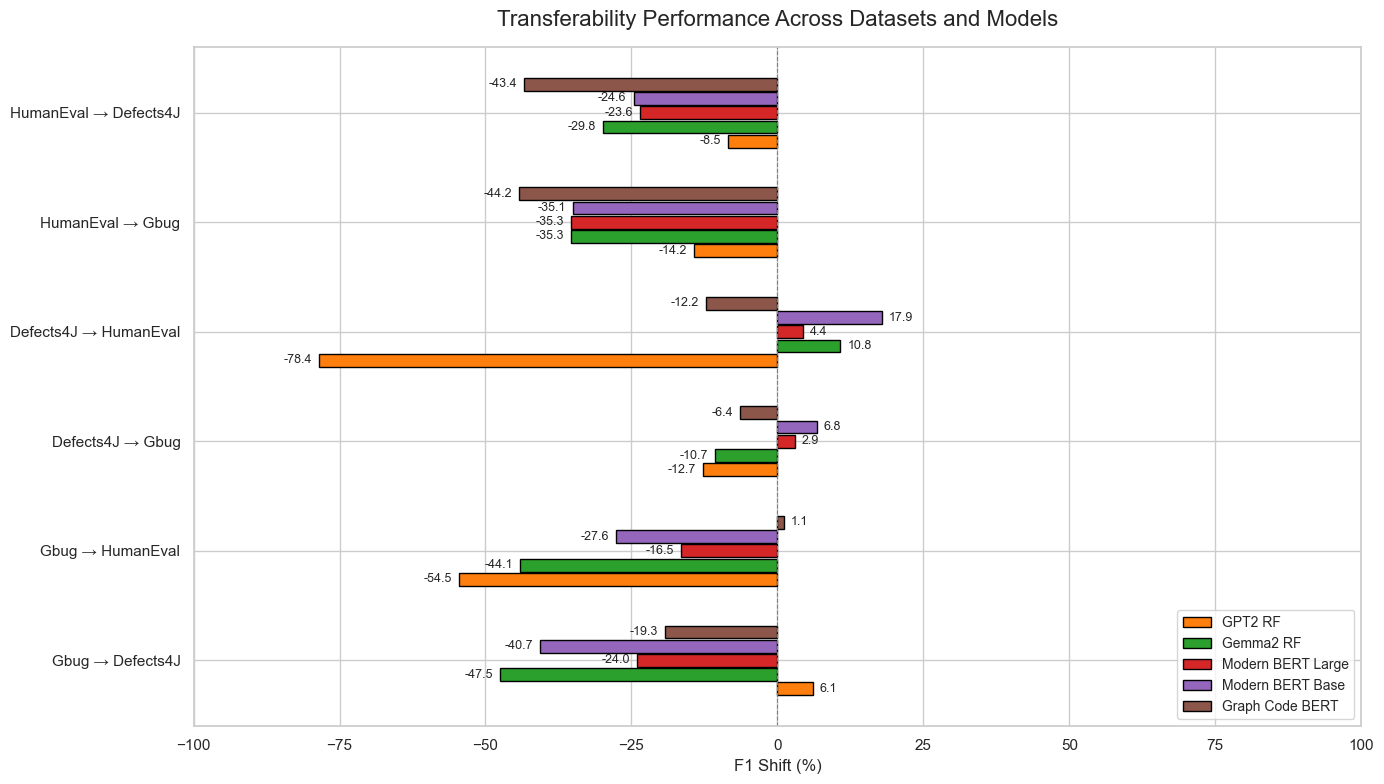

In [105]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set(style="whitegrid")

# Transfer direction labels
labels = [
    "Gbug → Defects4J", "Gbug → HumanEval",
    "Defects4J → Gbug", "Defects4J → HumanEval",
    "HumanEval → Gbug", "HumanEval → Defects4J",
]

# Values for each model
all_values = [
    # [
    #     transf_knn_gbug.on_defects, transf_knn_gbug.on_humaneval,
    #     transf_knn_defects.on_gbug, transf_knn_defects.on_humaneval,
    #     transf_knn_humaneval.on_gbug, transf_knn_humaneval.on_defects,
    # ],
    # [
    #     transf_rf_gbug.on_defects, transf_rf_gbug.on_humaneval,
    #     transf_rf_defects.on_gbug, transf_rf_defects.on_humaneval,
    #     transf_rf_humaneval.on_gbug, transf_rf_humaneval.on_defects,
    # ],
    [
        transf_rf_gbug_gpt2.on_defects, transf_rf_gbug_gpt2.on_humaneval,
        transf_rf_defects4j_gpt2.on_gbug, transf_rf_defects4j_gpt2.on_humaneval,
        transf_rf_humaneval_gpt2.on_gbug, transf_rf_humaneval_gpt2.on_defects,
    ],
    [
        transf_rf_gbug_gemma2.on_defects, transf_rf_gbug_gemma2.on_humaneval,
        transf_rf_defects4j_gemma2.on_gbug, transf_rf_defects4j_gemma2.on_humaneval,
        transf_rf_humaneval_gemma2.on_gbug, transf_rf_humaneval_gemma2.on_defects,
    ],
    [
        transf_modern_bert_large_gbug_on_defects, transf_modern_bert_large_gbug_on_human,
        transf_modern_bert_large_defects_on_gbug, transf_modern_bert_large_defects_on_human,
        transf_modern_bert_large_humaneval_on_gbug, transf_modern_bert_large_humaneval_on_defects,
    ],
    [
        transf_modern_bert_base_gbug.on_defects, transf_modern_bert_base_gbug.on_humaneval,
        transf_modern_bert_base_defects.on_gbug, transf_modern_bert_base_defects.on_humaneval,
        transf_modern_bert_base_humaneval.on_gbug, transf_modern_bert_base_humaneval.on_defects,
    ],
    [
        transf_graph_code_bert_gbug.on_defects, transf_graph_code_bert_gbug.on_humaneval,
        transf_graph_code_bert_defects.on_gbug, transf_graph_code_bert_defects.on_humaneval,
        transf_graph_code_bert_humaneval.on_gbug, transf_graph_code_bert_humaneval.on_defects,
    ],
]

methods = [#'KNN', 
           #'Random Forest', 
           'GPT2 RF', 
           "Gemma2 RF",
           'Modern BERT Large', 'Modern BERT Base', 'Graph Code BERT']
colors = [
   # '#1f77b4',  # Blue
    #'#ff7f0e',  # Orange
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#8c564b',  # Brown
]
x = np.arange(len(labels))
width = 0.13

fig, ax = plt.subplots(figsize=(14, 8))

# Draw bars
for i, (method_vals, method_name, color) in enumerate(zip(all_values, methods, colors)):
    offset = (i - len(all_values)/2) * width + width/2
    for j, val in enumerate(method_vals):
        if not np.isnan(val):
            ax.barh(x[j] + offset, val, height=width * 0.9,
                    label=method_name if j == 0 else "",
                    color=color, edgecolor='black')
            ax.annotate(f'{val:.1f}',
                        xy=(val, x[j] + offset),
                        xytext=(5 if val >= 0 else -5, 0),
                        textcoords='offset points',
                        ha='left' if val >= 0 else 'right',
                        va='center',
                        fontsize=9)

# Style the plot
ax.set_yticks(x)
ax.set_yticklabels(labels, fontsize=11)
ax.set_xlabel("F1 Shift (%)", fontsize=12)
ax.set_title("Transferability Performance Across Datasets and Models", fontsize=16, pad=15)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
ax.set_xlim(-100, 100)

# Remove duplicate labels
handles, labels_uniq = ax.get_legend_handles_labels()
unique = dict(zip(labels_uniq, handles))
ax.legend(unique.values(), unique.keys(), loc='lower right', fontsize=10, frameon=True)

plt.tight_layout()
plt.savefig("transferability_performance_cleaned.png", dpi=300)
plt.show()
